# Data Preprocessing and QC

In [29]:
### First install and import packages if missing
# %pip install polars
# %pip install matplotlib
# %pip install seaborn
# %pip install pyarrow

### Restart Kernel then import packages
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pandas as pd
%matplotlib inline

## 1. Loading Pillar Project Data

In [68]:
pillar_clinvar_df = pl.read_csv(
    "../1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    ## all use Int64 for consistency
    pl.col("hg38_start").cast(pl.Int64).alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant"),
    pl.lit(True).alias("pillar_tested")
)
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Original pillar dataset shape: (1053945, 103)
Filtered missense/SNP pillar dataset shape: (121504, 104)
Number of unique genes: 33
Number of unique gene variants: 61091


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,pillar_tested,aa_change
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,bool,str
27534,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3483509,"""ASPA_Ala148Asp""",true,"""Ala148Asp"""
8857,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3483509,"""ASPA_Ala148Asp""",true,"""Ala148Asp"""
27540,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3483509,"""ASPA_Ala148Gly""",true,"""Ala148Gly"""
8863,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_

### Summary of Pillar Data

Text(0.5, 1.0, 'Number of variants per gene in Pillar Project dataset')

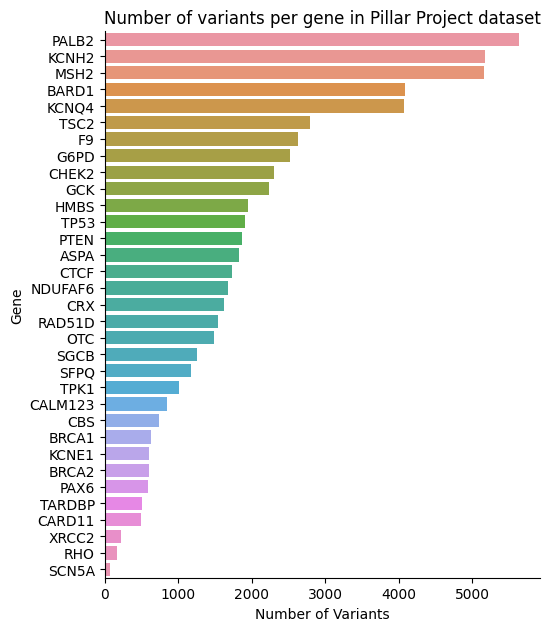

In [31]:
g = sns.catplot(data=pillar_clinvar_single_aa_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=6, aspect=.9)
plt.title("Number of variants per gene in Pillar Project dataset")

## 2. Loading VarChAMP consolidated dataset

### 2.1 OnePerc VarChAMP

In [32]:
def map_chr(num):
    if num == 23:
        return "X"
    elif num == 24:
        return "Y"
    elif num == 12920:
        return "MT"
    else:
        return str(num)

In [33]:
varchamp_seq_code = pl.read_csv("../1_inputs/sequence_confirmation_class_code.tsv", separator="\t")
varchamp_seq_code

id,description
i64,str
1,"""perfectly validated"""
2,"""partially validated, >= 50% co…"
3,"""wild type"""
4,"""partial wild type, target not …"
5,"""target and off-target mutation…"
6,"""off-target mutation, >= 50% co…"
7,"""truncated, < 50% coverage"""
99,"""no reads"""


In [34]:
varchamp_seq_df = pl.read_csv("../1_inputs/VarChampSeqConfirmationResult.tsv", separator="\t")

## clean up data
varchamp_seq_df = varchamp_seq_df.with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
).with_columns(
    pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
    pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Int64).alias("nuc_loc"),
    pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
    pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
).with_columns(
    pl.col("chr_num")
    .map_elements(map_chr, return_dtype=pl.String)
    .str.strip_chars()
    .alias("Chrom")
).rename(
    {
        "orf_id_wt": "orf_id",
        "mutation_id_old": "mut_id"
    }
)

# Convert columns to integer (NULL -> None)
columns_to_cast = [
    "entry_sequence_confirmation_class",
    "db_sequence_confirmation_class",
    "n2h_sequence_confirmation_class",
    "n2h_ref_sequence_confirmation_class",
    "dualip_sequence_confirmation_class",
    "dualip_ref_sequence_confirmation_class",
    "mislocalization_sequence_confirmation_class",
    "mislocalization_ref_sequence_confirmation_class"
]

varchamp_seq_df = varchamp_seq_df.with_columns([
    pl.col(col).cast(pl.Int64, strict=False) for col in columns_to_cast
])

# Define masks for allele filtering
entry_good = pl.col("entry_sequence_confirmation_class").is_in([1, 2])
entry_discard = pl.col("entry_sequence_confirmation_class").is_in([3, 4, 5, 6])
entry_null_like = pl.col("entry_sequence_confirmation_class").is_in([7, 99]) | pl.col("entry_sequence_confirmation_class").is_null()

# At least one expression vector is good
any_expression_good = (
    pl.col("db_sequence_confirmation_class").is_in([1, 2]) |
    # pl.col("n2h_sequence_confirmation_class").is_in([1, 2]) |
    pl.col("dualip_sequence_confirmation_class").is_in([1, 2]) |
    pl.col("mislocalization_sequence_confirmation_class").is_in([1, 2])
)

# Combine logic
varchamp_seq_df = varchamp_seq_df.filter(
    entry_good | (entry_null_like & any_expression_good)
)

display(varchamp_seq_df)

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,alt_allele,Chrom
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i64,str,str,str
"""GBA1""","""ENSG00000177628""",2,6,"""CCSBVarC000001""","""ALE0000584""","""NC_000001.11:155240033:C:G""","""160G>C""","""Val54Leu""","""RC4""","""RC4_Mut_GDEh1026""","""H01""","""GDEhDisVCh_40054""","""F12""","""2""","""RC4_Mut_GDDh1026""","""H01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,2,0,null,null,0,null,null,0,null,null,"""GBA1_Val54Leu""",1,155240033,"""C""","""G""","""1"""
"""GBA1""","""ENSG00000177628""",2,73,"""CCSBVarC000002""","""ALE00000002""","""NC_000001.11:155238225:G:A""","""670C>T""","""Leu224Phe""","""RC4""","""RC4_Mut_GDEh1026""","""E01""","""GDEhDisVCh_40054""","""C12""","""2""","""RC4_Mut_GDDh1026""","""E01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,1,0,null,null,0,null,null,0,null,null,"""GBA1_Leu224Phe""",1,155238225,"""G""","""A""","""1"""
"""GBA1""","""ENSG00000177628""",2,113,"""CCSBVarC000003""","""ALE00000003""","""NC_000001.11:155237453:C:T""","""887G>A""","""Arg296Gln""","""RC4""","""RC4_Mut_GDEh1026""","""F01""","""GDEhDisVCh_40054""","""D12""","""2""","""RC4_Mut_GDDh1026""","""F01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,7,0,null,null,0,null,null,0,null,null,"""GBA1_Arg296Gln""",1,155237453,"""C""","""T""","""1"""
"""GBA1""","""ENSG00000177628""",2,231,"""CCSBVarC000004""","""ALE00000004""","""NC_000001.11:155235252:A:G""","""1448T>C""","""Leu483Pro""","""RC4""","""RC4_Mut_GDEh1026""","""G01""","""GDEhDisVCh_40054""","""E12""","""2""","""RC4_Mut_GDDh1026""","""G01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,2,0,null,null,0,null,null,0,null,null,"""GBA1_Leu483Pro""",1,155235252,"""A""","""G""","""1"""
"""GBA1""","""ENSG00000177628""",2,213510,"""CCSBVarC003869""","""ALE00003869""","""NC_000001.11:155239934:G:A""","""259C>T""","""Arg87Trp""","""CEGS2""","""CegsMutGDEh1035""","""B03""","""GDEhDisVCh_40054""","""B02""","""2""","""CegsMutGDDh1035""","""B03""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,2,0,null,null,0,null,null,0,null,null,"""GBA1_Arg87Trp""",1,155239934,"""G""","""A""","""1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SRY""","""ENSG00000184895""",100070152,229149,"""CCSBVarC007069""","""ALE00007067""","""NC_000024.10:2787412:C:T""","""192G>A""","""Met64Ile""","""CEGS2""","""CegsMutGDEh1023""","""D05""","""GDEhDisVCh_40029""","""D09""","""1""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""SRY_Met64Ile""",24,2787412,"""C""","""T""","""Y"""
"""SRY""","""ENSG00000184895""",100070152,229151,"""CCSBVarC007072""","""ALE00007070""","""NC_000024.10:2787267:C:T""","""337G>A""","""Ala113Thr""","""CEGS2""","""CegsMutGDEh1023""","""F09""","""GDEhDisVCh_40029""","""H09""","""1""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""SRY_Ala113Thr""",24,2787267,"""C""","""T""","""Y"""
"""SRY""","""ENSG00000184895""",100070152,229152,"""CC

In [35]:
varchamp_seq_df.unique("entry_sequence_confirmation_class")

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,alt_allele,Chrom
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i64,str,str,str
"""NHERF1""","""ENSG00000109062""",25,200008,"""CCSBVarC000005""","""ALE00000005""","""NC_000017.11:74749174:C:G""","""328C>G""","""Leu110Val""","""CEGS2""","""CegsMutGDEh1043""","""G10""","""NULL""","""NULL""","""NULL""","""CegsMutGDDh1043""","""G10""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",0,null,1,1,0,null,null,0,null,null,0,null,null,"""NHERF1_Leu110Val""",17,74749174,"""C""","""G""","""17"""
"""ASAH1""","""ENSG00000104763""",837,2021,"""CCSBVarC000097""","""ALE00000097""","""NC_000008.11:18069818:C:T""","""277G>A""","""Val93Ile""","""RC4""","""RC4_Mut_GDEh1019""","""E12""","""GDEhDisVCh_40039""","""G09""","""1""","""RC4_Mut_GDDh1019""","""E12""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,99,1,1,0,null,null,0,null,null,0,null,null,"""ASAH1_Val93Ile""",8,18069818,"""C""","""T""","""8"""
"""GBA1""","""ENSG00000177628""",2,6,"""CCSBVarC000001""","""ALE0000584""","""NC_000001.11:155240033:C:G""","""160G>C""","""Val54Leu""","""RC4""","""RC4_Mut_GDEh1026""","""H01""","""GDEhDisVCh_40054""","""F12""","""2""","""RC4_Mut_GDDh1026""","""H01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,2,0,null,null,0,null,null,0,null,null,"""GBA1_Val54Leu""",1,155240033,"""C""","""G""","""1"""
"""NHERF1""","""ENSG00000109062""",25,252,"""CCSBVarC000005""","""ALE00000005""","""NC_000017.11:74749174:C:G""","""328C>G""","""Leu110Val""","""RC4""","""RC4_Mut_GDEh1008""","""F09""","""GDEhDisVCh_40045""","""E04""","""1""","""RC4_Mut_GDDh1008""","""F09""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,7,1,1,0,null,null,0,null,null,0,null,null,"""NHERF1_Leu110Val""",17,74749174,"""C""","""G""","""17"""
"""CANT1""","""ENSG00000171302""",117,213580,"""CCSBVarC004815""","""ALE00004815""","""NC_000017.11:78993677:G:T""","""1079C>A""","""Ala360Asp""","""CEGS2""","""CegsMutGDEh1015""","""G03""","""GDEhDisVCh_40028""","""E06""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,2,0,null,0,null,null,0,null,null,0,null,null,"""CANT1_Ala360Asp""",17,78993677,"""G""","""T""","""17"""


In [36]:
# varchamp_seq_df.write_csv("../3_outputs/VarChampSeqConfirmationResult_Alleles_Pass_QC.tsv", separator="\t")

In [37]:
# varchamp_seq_cons_df = pl.read_csv("../1_inputs/VarChamp_Consolidated_allele_collection.tsv", separator="\t", infer_schema_length=10000)
# varchamp_seq_cons_df = varchamp_seq_df.with_columns(
#     # pl.col("symbol").str.replace_all("NULL", "KCNE1").alias("symbol"),
#     pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
# )
# .with_columns(
#     pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
#     pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Float64).alias("nuc_loc"),
#     pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
#     pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
# ).with_columns(
#     pl.col("chr_num")
#     .map_elements(map_chr, return_dtype=pl.String)
#     .str.strip_chars()
#     .alias("Chrom")
# )
# varchamp_seq_df["mutation_id_old"].unique()
# varchamp_seq_df.filter((pl.col("nuc_ref").str.len_chars()>1)|(pl.col("nuc_alt").str.len_chars()>1))
# varchamp_seq_df.unique(subset="gene_variant")

### 2.2 Load CAVA dataset

In [38]:
cava = pl.read_csv("../1_inputs/B13_B14_Metadata_update_SPDI.csv")
cava = cava.rename(
    {"gene_allele": "gene_variant"}
).with_columns(
    # regex replace a single trailing underscore
    pl.col("gene_variant").str.replace(r"_$", "", literal=False).alias("gene_variant")
)

cols_to_keep = [
    "spdi",
    "symbol",
    "gene_variant",
    "node_type",
    "orf_id_wt",
    "ccsb_mutation_id",
    "nt_change_cdna",
    "aa_change",
    "dest_well",
    "dest_plate",
    "imaging_well",
    "imaging_plate_R1",
    "imaging_plate_R2"
]

cava = cava.select(
    cols_to_keep
).with_columns(
    pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
    pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Int64).alias("nuc_loc"),
    pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
    pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
).with_columns(
    pl.col("chr_num")
    .map_elements(map_chr, return_dtype=pl.String)
    .str.strip_chars()
    .alias("Chrom")
).rename(
    {
        "orf_id_wt": "orf_id",
    }
)

# filter for node_type == "allele" and spdi null/NA
missing_spdi_cava = cava.filter(
    (pl.col("node_type") == "allele") &
    pl.col("spdi").is_null()
)

# get the count
print("Number of CAVA alleles that are missing spdi is:", missing_spdi_cava.shape[0]) # these appear to come from RC4 mutant collection

cava_imaging_df = cava.filter(
    (pl.col("node_type") == "allele")
    # & pl.col("spdi").is_not_null()
)
display(cava_imaging_df)

Number of CAVA alleles that are missing spdi is: 5


spdi,symbol,gene_variant,node_type,orf_id,ccsb_mutation_id,nt_change_cdna,aa_change,dest_well,dest_plate,imaging_well,imaging_plate_R1,imaging_plate_R2,chr_num,nuc_loc,ref_allele,alt_allele,Chrom
str,str,str,str,i64,str,str,str,str,str,str,str,str,i32,i64,str,str,str
"""NC_000023.11:153740155:C:T""","""ABCD1""","""ABCD1_Arg518Trp""","""allele""",100008637,"""CCSBVarC007022""","""1552C>T""","""Arg518Trp""","""B01""","""527_CAVA_Array_P01""","""C01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""",23,153740155,"""C""","""T""","""X"""
"""NC_000023.11:153736195:C:G""","""ABCD1""","""ABCD1_Arg389Gly""","""allele""",100008637,"""CCSBVarC007023""","""1165C>G""","""Arg389Gly""","""C01""","""527_CAVA_Array_P01""","""E01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""",23,153736195,"""C""","""G""","""X"""
"""NC_000023.11:153740156:G:A""","""ABCD1""","""ABCD1_Arg518Gln""","""allele""",100008637,"""CCSBVarC007021""","""1553G>A""","""Arg518Gln""","""D01""","""527_CAVA_Array_P01""","""G01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""",23,153740156,"""G""","""A""","""X"""
"""NC_000003.12:52403242:T:C""","""BAP1""","""BAP1_Ser596Gly""","""allele""",3760,"""CCSBVarC009473""","""1786A>G""","""Ser596Gly""","""F01""","""527_CAVA_Array_P01""","""K01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""",3,52403242,"""T""","""C""","""3"""
"""NC_000003.12:52403877:G:T""","""BAP1""","""BAP1_Thr423Lys""","""allele""",3760,"""CCSBVarC009476""","""1268C>A""","""Thr423Lys""","""G01""","""527_CAVA_Array_P01""","""M01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""",3,52403877,"""G""","""T""","""3"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NC_000007.14:45076028:G:A""","""CCM2""","""CCM2_Gly436Ser""","""allele""",3928,"""CCSBVarC038848""","""1306G>A""","""Gly436Ser""","""G03""","""527_CAVA_Array_P08""","""N06""","""B13A7A8P2_R1""","""B14A7A8P2_R2""",7,45076028,"""G""","""A""","""7"""
"""NC_000007.14:45076039:G:A""","""CCM2""","""CCM2_Met439Ile""","""allele""",3928,"""CCSBVarC038849""","""1317G>A""","""Met439Ile""","""H03""","""527_CAVA_Array_P08""","""P06""","""B13A7A8P2_R1""","""B14A7A8P2_R2""",7,45076039,"""G""","""A""","""7"""
"""NC_000007.14:45076040:G:A""","""CCM2""","""CCM2_Asp440Asn""","""allele""",3928,"""CCSBVarC038850""","""1318G>A""","""Asp440Asn""","""A04""","""527_CAVA_Array_P08""","""B08""","""B13A7A8P2_R1""","""B14A7A8P2_R2""",7,45076040,"""G""","""A""","""7"""


In [39]:
cava_ppi_df = pl.read_csv("../1_inputs/Edgotyping_CAVA_alleles.csv")
cava_ppi_df = cava_ppi_df.with_columns(
    pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
    pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Int64).alias("nuc_loc"),
    pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
    pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
).with_columns(
    pl.col("chr_num")
    .map_elements(map_chr, return_dtype=pl.String)
    .str.strip_chars()
    .alias("Chrom")
)
cava_ppi_df

symbol,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,seq_confirmed_wt_ppi,seq_confirmed_allele_ppi,seq_confirmed_final,chr_num,nuc_loc,ref_allele,alt_allele,Chrom
str,str,str,str,str,str,str,i64,i64,i64,i32,i64,str,str,str
"""MYD88""","""CCSBVarC000008""","""ALE00000008""","""NC_000003.12:38140510:C:T""","""586C>T""","""Arg196Cys""","""Lacoste""",1,1,1,3,38140510,"""C""","""T""","""3"""
"""GFAP""","""CCSBVarC004668""","""ALE00004668""","""NC_000017.11:44913342:T:G""","""707A>C""","""Lys236Thr""","""Lacoste""",1,1,1,17,44913342,"""T""","""G""","""17"""
"""AHCY""","""CCSBVarC016789""","""ALE00016390""","""NC_000020.11:34290421:T:C""","""883A>G""","""Ile295Val""","""Lacoste""",1,1,1,20,34290421,"""T""","""C""","""20"""
"""RP2""","""CCSBVarC015020""","""ALE00016035""","""NC_000023.11:46860064:G:A""","""845G>A""","""Arg282Gln""","""Lacoste""",1,1,1,23,46860064,"""G""","""A""","""X"""
"""RAD51D""","""CCSBVarC024877""","""ALE00029794""","""NC_000017.11:35101239:C:T""","""865G>A""","""Gly289Ser""","""CAVA""",1,1,1,17,35101239,"""C""","""T""","""17"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RP2""","""CCSBVarC014978""","""ALE00015981""","""NC_000023.11:46837149:C:T""","""49C>T""","""Pro17Ser""","""Lacoste""",1,1,1,23,46837149,"""C""","""T""","""X"""
"""TSFM""","""CCSBVarC017062""","""ALE00016889""","""NC_000012.12:57796324:G:C""","""719G>C""","""Cys240Ser""","""Lacoste""",1,1,1,12,57796324,"""G""","""C""","""12"""
"""RP2""","""CCSBVarC015032""","""ALE00016049""","""NC_000023.11:46877562:T:C""","""941T>C""","""Ile314Thr""","""Lacoste""",1,1,1,23,46877562,"""T""","""C""","""X"""


### 2.3 Load OnePercent Dataset (batches 7-8, 11-12, 15-16) by Chloe

In [40]:
# # oneper_shift is the latest onepercent (Batches 7 & 8) platemap, including sanger sequencing results to identify plating shifts due to robotic rearray errors plus pooled sequencing results
# oneper_shift = pl.read_csv("../1_inputs/2025_06_02_A1_metadata_VarChampSeqConfirmationResult_merge_update.csv")
# # # Select only clones that experienced rearray shift
# # oneper_shift = oneper_shift.filter(
# #     (pl.col("seq_position_off") != 0) &
# #     pl.col("seq_position_off").is_not_null()
# # )

# # oneper_seq contians pooled sequencing results from Tong
# oneper_seq = pl.read_csv("../1_inputs/VarChampSeqConfirmation1percent.tsv", separator="\t")
# oneper_seq = oneper_seq.rename({
#     "seq_confirmation":       "pool_seq_confirmation",
#     "seq_confirmation_class": "pool_seq_confirmation_class"
# })

# # Double check Tanisha merged pooled sequencing results correctly
# oneper_shift = oneper_shift.join(
#     # grab only the two keys + the two cols you want from oneper
#     oneper_seq.select([
#         "entry_well",
#         "entry_plate",
#         "pool_seq_confirmation",
#         "pool_seq_confirmation_class",
#     ]),
#     left_on  = ["source_well",  "source_plate"],
#     right_on = ["entry_well",    "entry_plate"],
#     how      = "left",
# )

# mismatch_count = oneper_shift.filter(
#     pl.col("seq_confirmation_class") != pl.col("pool_seq_confirmation_class")
# ).height

# if mismatch_count == 0:
#     print("Tanisha merged pooled sequencing file with A1 platemap correctly.")
# else:
#     print(f"Found {mismatch_count} mismatches in the merge.")

# # drop duplicate columns
# oneper_shift = oneper_shift.drop([
#     "seq_confirmation",
#     "seq_confirmation_class"
# ])

# # === Due to the rearray error, rows are not currently aligned perfectly. The next chunk fixes this ===
# # change nulls to 0
# oneper_shift = oneper_shift.with_columns(
#     pl.col("seq_position_off")
#       .fill_null(0)
#       .alias("seq_position_off")
# )

# # the columns you want to shift/duplicate
# cols = [
#     "source_plate",
#     "source_well",
#     "pool_seq_confirmation",
#     "pool_seq_confirmation_class",
#     "orf_id_wt",
#     "node_type",
#     "ccsb_mutation_id",
#     "nt_change_cdna",
#     "aa_change"
# ]

# oneper_shift = (
#     oneper_shift
#       # 1) add a row-index
#     .with_row_index("idx")
#       # 2) duplicate your final_* columns & compute the join index
#     .with_columns(
#         # duplicate
#         [pl.col(c).alias(f"final_{c}") for c in cols]
#         # compute where to pull from
#         + [(pl.col("idx") - pl.col("seq_position_off")).alias("join_idx")]
#     )
# )

# # 3) build a mini‐table of shifted originals
# shift_df = oneper_shift.select(
#     pl.col("idx"),
#     *[pl.col(c).alias(f"{c}_shift") for c in cols]
# ).with_columns(
#     pl.col("idx").cast(pl.Int64).alias("idx")
# )

# # 4) join, overwrite via fill_null, and drop helpers
# oneper_shift = (
#     oneper_shift
#       .join(shift_df, left_on="join_idx", right_on="idx", how="left")
#       .with_columns([
#           # if x_shift exists use it, else keep your initial final_x
#           pl.col(f"{c}_shift")
#             .fill_null(pl.col(f"final_{c}"))
#             .alias(f"final_{c}")
#           for c in cols
#       ])
#       .drop(
#         ["idx", "join_idx"] 
#         + [f"{c}_shift" for c in cols]
#       )
# )

# # done—your final_* columns have been shifted wherever seq_position_off ≠ 0
# oneper = oneper_shift.select(
#     [
#         "final_symbol",
#         "final_gene_allele",
#         "final_source_plate",
#         "final_source_well",
#         "imaging_well",
#         "imaging_plate_R1",
#         "imaging_plate_R2",        
#         "final_node_type",
#         "final_orf_id_wt",
#         "final_ccsb_mutation_id",
#         "final_nt_change_cdna",
#         "final_aa_change",
#         "final_pool_seq_confirmation",
#         "final_pool_seq_confirmation_class"
#     ]
# )

# # drop the "final_" prefix from every column that has it
# oneper = oneper.rename({
#     c: c.replace("final_", "")
#     for c in oneper.columns
#     if c.startswith("final_")
# })

# # === Append spdi to oneper platemap ===
# oneper_meta = pl.read_csv(
#     "../1_inputs/Chloe_muts_1_percent_VarCahmp.tsv",
#     separator="\t",
#     infer_schema_length=10000,   # look at more rows when inferring
#     schema_overrides={           # override just that one column
#         "pct_orf_covered_by_protein": pl.Float64
#     }
# )

# # === Double check all mutants are annotated in the metadata file ===
# # 1) Unique IDs in each
# meta_ids = oneper_meta.select("mutation_id").unique()
# ccsb_ids = oneper.select("ccsb_mutation_id").unique()

# total_meta = meta_ids.height
# total_ccsb = ccsb_ids.height

# # 2) How many meta IDs appear in oneper$ccsb_mutation_id?
# meta_in_ccsb = meta_ids.filter(
#     pl.col("mutation_id").is_in(ccsb_ids["ccsb_mutation_id"])
# ).height

# # 3) How many oneper$ccsb_mutation_id appear in oneper_meta$mutation_id?
# ccsb_in_meta = ccsb_ids.filter(
#     pl.col("ccsb_mutation_id").is_in(meta_ids["mutation_id"])
# ).height

# # 4) Print counts and percentages
# print(f"\noneper ccsb_mutation_id → oneper_meta mutation_id:")
# print(f"  {ccsb_in_meta} / {total_ccsb} = {ccsb_in_meta/total_ccsb:.2%}")

# # === Append spdi and other metadata to oneper platemap ===
# # 1) list out the columns you want from oneper_meta
# meta_cols = [
#     "symbol_gencode_v44",
#     "chr",
#     "chr_pos_37",
#     "chr_pos_38",
#     "ccsb_allele_id",
#     "ccsb_mutation_id",
#     "ensembl_gene_id",
#     "ensembl_protein_id",
#     "pct_identical_protein",
#     "pct_protein_covered_by_orf",
#     "pct_orf_covered_by_protein",
#     "entrez_gene_id",
#     "spdi",
# ]

# # 2) build the join
# oneper = oneper.join(
#     # select only the join key + the meta columns
#     oneper_meta.select(["mutation_id", *meta_cols]),
#     left_on  = "ccsb_mutation_id",
#     right_on = "mutation_id",
#     how      = "left",
# )

# # 4) verify
# oneper.head()

# # Drop all control wells and empty wells
# oneper = oneper.filter(
#     # keep rows where node_type does NOT contain "C"
#     ~pl.col("node_type").str.contains("C")
#     # and gene_allele is not null
#     & pl.col("gene_allele").is_not_null()
# )

# # filter for node_type == "allele" and spdi null/NA
# missing_spdi_oneper = oneper.filter(
#     (pl.col("node_type") == "allele") &
#     pl.col("spdi").is_null()
# )

# # get the count
# print("Number of OnePercent alleles that are missing spdi is:", missing_spdi_oneper.shape[0]) # these appear to be spiked in minipreps

# # rename
# oneper = oneper.rename({
#     "gene_allele": "gene_variant"
# })

# # === Write final onepercent (B7-8) file ===
# # oneper.write_csv("../3_outputs/onepercent_B7-8_A1_seq_and_meta.csv")

In [41]:
# print(
#     len(set(cava["gene_variant"]).intersection(set(pillar_clinvar_single_aa_df["gene_variant"].unique()))),
#     "CAVA alleles out of",
#     len(cava.filter(pl.col("node_type") == "allele")["gene_variant"].unique()),
#     "mapped to the pillar project dataframe according to gene_variant."
# )
# print(
#     len(set(cava["spdi_trimmed"]).intersection(set(pillar_clinvar_single_aa_df["spdi_trimmed"].unique()))),
#     "CAVA alleles out of",
#     len(cava["spdi_trimmed"].unique()),
#     "mapped to the pillar project dataframe according to spdi_trimmed.\n"
# )

# print(
#     len(set(oneper["gene_variant"]).intersection(set(pillar_clinvar_single_aa_df["gene_variant"].unique()))),
#     "OnePercent alleles out of",
#     len(oneper["gene_variant"].unique()), ##.filter(pl.col("node_type") == "allele")
#     "mapped to the pillar project dataframe according to gene_variant."
# )
# print(
#     len(set(oneper["spdi_trimmed"]).intersection(set(pillar_clinvar_single_aa_df["spdi_trimmed"].unique()))),
#     "OnePercent alleles out of",
#     len(oneper["spdi_trimmed"].unique()),
#     "mapped to the pillar project dataframe according to spdi_trimmed.\n"
# )

# print(
#     len(set(varchamp_df["gene_variant"]).intersection(set(pillar_clinvar_single_aa_df["gene_variant"].unique()))),
#     "combined alleles out of",
#     len(varchamp_df["gene_variant"].unique()), ## .filter(pl.col("node_type") == "allele")
#     "mapped to the pillar project dataframe according to gene_variant."
# )

# print(
#     len(set(varchamp_df["spdi_trimmed"]).intersection(set(pillar_clinvar_single_aa_df["spdi_trimmed"].unique()))),
#     "CAVA alleles out of",
#     len(varchamp_df["spdi_trimmed"].unique()),
#     "mapped to the pillar project dataframe according to spdi_trimmed."
# )

### 2.4 Merge CAVA and OnePercent

In [42]:
# oneper = varchamp_seq_df
# # create a trimmed spdi for mapping so I don't have to pull RefSeq chromosome ID for pillar project dataframe
# oneper = oneper.with_columns(
#     pl.col("spdi")
#       # match:  ^NC_0+(\d+)   then  \.\d+:   and replace with “\1:”
#       .str.replace(r"^NC_0+(\d+)\.\d+:", r"$1:", literal=False)
#       .alias("spdi_trimmed")
# )

# cava = cava.with_columns(
#     pl.col("spdi")
#       # match:  ^NC_0+(\d+)   then  \.\d+:   and replace with “\1:”
#       .str.replace(r"^NC_0+(\d+)\.\d+:", r"$1:", literal=False)
#       .alias("spdi_trimmed")
# )

# pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.with_columns(
#     pl.concat_str(
#         [
#             pl.col("Chrom"),
#             pl.col("nuc_loc").cast(pl.Int64),
#             pl.col("hgvs_c").str.extract(r"([A-Za-z])>", 1),
#             # capture the single-letter just after the ">"
#             pl.col("hgvs_c").str.extract(r">([A-Za-z])", 1),
#         ],
#         separator=":"
#     ).alias("spdi_trimmed")
# )

In [43]:
varchamp_df = pl.concat(
    [
        varchamp_seq_df, 
        cava_imaging_df,
        cava_ppi_df
    ],
    how="diagonal_relaxed",
    rechunk=True
).with_columns([
    # Fix: Use concat_str for the varid string concatenation
    pl.concat_str([
        pl.col("Chrom"),
        pl.lit("-"),
        pl.col("nuc_loc").cast(pl.String),
        pl.lit("-"),
        pl.col("ref_allele"),
        pl.lit("-"),
        pl.col("alt_allele")
    ]).alias("varid")
])

In [44]:
varchamp_df.filter(pl.col("Chrom")=="X")

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,alt_allele,Chrom,node_type,nt_change_cdna,dest_well,dest_plate,imaging_well,imaging_plate_R1,imaging_plate_R2,seq_confirmed_wt_ppi,seq_confirmed_allele_ppi,seq_confirmed_final,varid
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,str
"""TSPAN7""","""ENSG00000156298""",1276,200447,"""CCSBVarC005846""","""ALE00005846""","""NC_000023.11:38675778:C:A""","""515C>A""","""Pro172His""","""CEGS2""","""CegsMutGDEh1030""","""H04""","""GDEhDisVCh_40090""","""G04""","""2""","""CegsMutGDDh1030""","""H04""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,1,0,null,null,0,null,null,0,null,null,"""TSPAN7_Pro172His""",23,38675778,"""C""","""A""","""X""",null,null,null,null,null,null,null,null,null,null,"""X-38675778-C-A"""
"""MTM1""","""ENSG00000171100""",1447,2694,"""CCSBVarC000171""","""ALE00000171""","""NC_000023.11:150598600:G:T""","""145G>T""","""Val49Phe""","""RC4""","""RC4_Mut_GDEh1027""","""E08""","""GDEhDisVCh_40058""","""G11""","""2""","""RC4_Mut_GDDh1027""","""E08""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,1,0,null,null,0,null,null,0,null,null,"""MTM1_Val49Phe""",23,150598600,"""G""","""T""","""X""",null,null,null,null,null,null,null,null,null,null,"""X-150598600-G-T"""
"""MTM1""","""ENSG00000171100""",1447,2711,"""CCSBVarC000172""","""ALE00000172""","""NC_000023.11:150641306:A:G""","""566A>G""","""Asn189Ser""","""RC4""","""RC4_Mut_GDEh1027""","""F08""","""GDEhDisVCh_40058""","""H11""","""2""","""RC4_Mut_GDDh1027""","""F08""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,1,0,null,null,0,null,null,0,null,null,"""MTM1_Asn189Ser""",23,150641306,"""A""","""G""","""X""",null,null,null,null,null,null,null,null,null,null,"""X-150641306-A-G"""
"""MTM1""","""ENSG00000171100""",1447,2768,"""CCSBVarC000173""","""ALE00000173""","""NC_000023.11:150660423:A:G""","""1406A>G""","""His469Arg""","""RC4""","""RC4_Mut_GDEh1027""","""G08""","""GDEhDisVCh_40058""","""A12""","""2""","""RC4_Mut_GDDh1027""","""G08""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,6,0,null,null,0,null,null,0,null,null,"""MTM1_His469Arg""",23,150660423,"""A""","""G""","""X""",null,null,null,null,null,null,null,null,null,null,"""X-150660423-A-G"""
"""MTM1""","""ENSG00000171100""",1447,200471,"""CCSBVarC003527""","""ALE00003527""","""NC_000023.11:150598663:C:T""","""208C>T""","""Leu70Phe""","""CEGS2""","""CegsMutGDEh1003""","""D05""","""GDEhDisVCh_40058""","""C01""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""MTM1_Leu70Phe""",23,150598663,"""C""","""T""","""X""",null,null,null,null,null,null,null,null,null,null,"""X-150598663-C-T"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RP2""",null,null,null,"""CCSBVarC014975""","""ALE00015978""","""NC_000023.11:46853854:G:T""","""481G>T""","""Asp161Tyr""","""Lacoste""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,23,468538

### 2.5 Merge with other metadata: ClinVar, gnomad, dbnsfp5.0a

Data collection for these three data frames could be found at https://github.com/broadinstitute/2025_laval_submitted/

In [45]:
df_clinvar_dedup_struct = pl.scan_parquet("/home/shenrunx/igvf/varchamp/2025_laval_submitted/4_compare_AI_scores/3_outputs/processed_data/dbnsfp/dbNSFP5.0a_variant.clin_var_re-annot_pdb_variants.parquet")
df_clinvar_dedup_struct.collect().head()

clinvar_id,#chr,pos(1-based),ref,alt,aaref,aaalt,rs_dbSNP,hg19_chr,hg19_pos(1-based),hg18_chr,hg18_pos(1-based),aapos,genename,Ensembl_geneid,Ensembl_transcriptid,Ensembl_proteinid,Uniprot_acc,Uniprot_entry,HGVSc_snpEff,HGVSp_snpEff,HGVSc_VEP,HGVSp_VEP,APPRIS,GENCODE_basic,TSL,VEP_canonical,MANE,cds_strand,refcodon,codonpos,codon_degeneracy,Ancestral_allele,AltaiNeandertal,Denisova,VindijiaNeandertal,ChagyrskayaNeandertal,…,nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,clinvar_nt_change,clinvar_aa_change,SPDI,RefSeq_mRNA,StarStatus,clinvar_clnsig_clean
str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,cat,str,str,i64,i64,str,cat,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,cat
"""2361281""","""21""",13628442,"""G""","""T""","""S""","""I""","""rs905107791""","""21""","""15000763""","""21""","""13922634""","""396""","""POTED""","""ENSG00000166351""","""ENST00000299443""","""ENSP00000299443""","""Q86YR6""","""POTED_HUMAN""","""c.1187G>T""","""p.Ser396Ile""","""c.1187G>T""","""p.Ser396Ile""","""principal1""","""Y""","""1""","""YES""","""Select""","""+""","""AGC""","""2""","""0""",""".""","""./.""","""./.""","""./.""","""./.""",…,"""-""","""RCV004201236""","""MedGen:CN169374""","""not specified""","""germline""","""germline""","""GRCh38""","""NC_000021.9""","""21""",13628442,13628442,"""21q11.2""","""criteria provided, single subm…",1,"""-""","""N""","""ClinGen:CA317768197""",2,2361281,13628442,"""G""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV003702401""","""-""","""-""","""1187G>T ""","""Ser396Ile""","""NC_000021.9:13628442:G:T""","""NM_174981.6""",1,"""4_VUS"""
"""2599176""","""21""",13630941,"""G""","""T""","""V""","""F""","""rs937658823""","""21""","""15003262""","""21""","""13925133""","""415""","""POTED""","""ENSG00000166351""","""ENST00000299443""","""ENSP00000299443""","""Q86YR6""","""POTED_HUMAN""","""c.1243G>T""","""p.Val415Phe""","""c.1243G>T""","""p.Val415Phe""","""principal1""","""Y""","""1""","""YES""","""Select""","""+""","""GTT""","""1""","""0""",""".""","""./.""","""./.""","""./.""","""./.""",…,"""-""","""RCV004345528""","""MedGen:CN169374""","""not specified""","""germline""","""germline""","""GRCh38""","""NC_000021.9""","""21""",13630941,13630941,"""21q11.2""","""criteria provided, single subm…",1,"""-""","""N""","""ClinGen:CA317768279""",2,2599176,13630941,"""G""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV004065319""","""-""","""-""","""1243G>T ""","""Val415Phe""","""NC_000021.9:13630941:G:T""","""NM_174981.6""",1,"""4_VUS"""
"""2486768""","""21""",13630977,"""G""","""A""","""V""","""M""",""".""","""21""","""15003298""","""21""","""13925169""","""427""","""POTED""","""ENSG00000166351""","""ENST00000299443""","""ENSP00000299443""","""Q86YR6""","""POTED_HUMAN""","""c.1279G>A""","""p.Val427Met""","""c.1279G>A""","""p.Val427Met""","""principal1""","""Y""","""1""","""YES""","""Select""","""+""","""GTG""","""1""","""0""",""".""","""./.""","""./.""","""./.""","""./.""",…,"""-""","""RCV004275341""","""MedGen:CN169374""","""not specified""","""germline""","""germline""","""GRCh38""","""NC_000021.9""","""21""",13630977,13630977,"""21q11.2""","""criteria provided, single subm…",1,"""-""","""N""","""ClinGen:CA409859409""",2,2486768,13630977,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV003905383""

In [46]:
CHROMOSOMES = [str(c) for c in list(range(1, 23))] + ['X', 'Y']
allele_freq_dfs = []
for chrom in CHROMOSOMES:
    try:
        allele_freq = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/processed_data/gnomad_allele_frequencies/chr{chrom}_allele_frequencies.txt",
                                separator="\t", has_header=False, 
                                new_columns=["chr","chr_pos_38","ref","alt","allele_freq"])
        allele_freq = allele_freq.with_columns(
            pl.col("chr").str.replace(r"\'", "").str.replace(r"\'", "").str.replace("chr", "")
        ).drop_nulls()
        # allele_freq = allele_freq.filter(~pl.all_horizontal(pl.all().is_null()))
        # print(allele_freq)
        allele_freq_dfs.append(allele_freq)
    except:
        continue

allele_freq_all = pl.concat(allele_freq_dfs)
allele_freq_gnomad = allele_freq_all.with_columns(
    pl.concat_str([pl.col("chr"),
                   pl.lit('-'),
                   pl.col("chr_pos_38").cast(pl.String),
                   pl.lit('-'),
                   pl.col("ref"),
                   pl.lit('-'),
                   pl.col("alt")
                   ]).alias("varid"),
    pl.col("allele_freq").alias("gnomad_af")
).drop(pl.col("allele_freq"))#.to_pandas()

allele_freq_gnomad

chr,chr_pos_38,ref,alt,varid,gnomad_af
str,i64,str,str,str,f64
"""1""",2028259,"""C""","""A""","""1-2028259-C-A""",6.8500e-7
"""1""",2028259,"""C""","""T""","""1-2028259-C-T""",0.001409
"""1""",2028260,"""G""","""A""","""1-2028260-G-A""",0.0217404
"""1""",5907193,"""CG""","""C""","""1-5907193-CG-C""",0.0
"""1""",5907194,"""G""","""A""","""1-5907194-G-A""",0.000013
…,…,…,…,…,…
"""X""",154863124,"""C""","""T""","""X-154863124-C-T""",0.000011
"""X""",154863125,"""G""","""A""","""X-154863125-G-A""",0.000004
"""X""",154863151,"""C""","""T""","""X-154863151-C-T""",0.000004


In [47]:
varchamp_clinvar_df = varchamp_df.join(
    df_clinvar_dedup_struct.collect(),
    left_on="spdi",
    right_on="SPDI",
    how="left"
)
varchamp_clinvar_df# = gene_info_clinvar.collect()

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,clinvar_nt_change,clinvar_aa_change,RefSeq_mRNA,StarStatus,clinvar_clnsig_clean
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,i64,str,str,str,str,str,str,cat,str,str,i64,i64,str,cat,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,cat
"""GBA1""","""ENSG00000177628""",2,6,"""CCSBVarC000001""","""ALE0000584""","""NC_000001.11:155240033:C:G""","""160G>C""","""Val54Leu""","""RC4""","""RC4_Mut_GDEh1026""","""H01""","""GDEhDisVCh_40054""","""F12""","""2""","""RC4_Mut_GDDh1026""","""H01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,2,0,null,null,0,null,null,0,null,null,"""GBA1_Val54Leu""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""GBA1""","""ENSG00000177628""",2,73,"""CCSBVarC000002""","""ALE00000002""","""NC_000001.11:155238225:G:A""","""670C>T""","""Leu224Phe""","""RC4""","""RC4_Mut_GDEh1026""","""E01""","""GDEhDisVCh_40054""","""C12""","""2""","""RC4_Mut_GDDh1026""","""E01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,1,0,null,null,0,null,null,0,null,null,"""GBA1_Leu224Phe""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""GBA1""","""ENSG00000177628""",2,113,"""CCSBVarC000003""","""ALE00000003""","""NC_000001.11:155237453:C:T""","""887G>A""","""Arg296Gln""","""RC4""","""RC4_Mut_GDEh1026""","""F01""","""GDEhDisVCh_40054""","""D12""","""2""","""RC4_Mut_GDDh1026""","""F01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,7,0,null,null,0,null,null,0,null,null,"""GBA1_Arg296Gln""",…,78973108,"""-""","""RCV000004573|RCV000079357|RCV0…","""MONDO:MONDO:0011945,MedGen:C18…","""Gaucher disease perinatal leth…","""germline;unknown""","""germline""","""GRCh38""","""NC_000001.11""","""1""",155237453,155237453,"""1q22""","""criteria provided, multiple su…",15,"""-""","""N""","""ClinGen:CA221417,UniProtKB:P04…",3,4328,155237453,"""C""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000232587|SCV000321701|SCV0…","""-""","""-""","""887G>A ""","""Arg296Gln""","""NM_000157.4""",2,"""1_Pathogenic"""
"""GBA1""","""ENSG00000177628""",2,231,"""CCSBVarC000004""","""ALE00000004""","""NC_000001.11:155235252:A:G""","""1448T>C""","""Leu483Pro""","""RC4""","""RC4_Mut_GDEh1026""","""G01""","""GDEhDisVCh_40054""","""E12""","""2""","""RC4_Mut_GDDh1026""","""G01""","""NULL""","""NULL""","""NULL""","""NULL""","""N

In [48]:
varchamp_clinvar_gnomad_df = varchamp_clinvar_df.join(
    allele_freq_gnomad,
    on="varid",
    how="left"
)

In [49]:
# varchamp_clinvar_gnomad_df.write_csv("../3_outputs/varchamp_clinvar_gnomad.tsv", separator="\t")

## 3. Merge two datasets

### 3.1 Merge by gene_variant

In [21]:
varchamp_pillar_by_var_df = varchamp_clinvar_gnomad_df.join(
    pillar_clinvar_single_aa_df,
    on="gene_variant",
    suffix="_pp",
    # how="full",
    # coalesce=True
)

display(
    varchamp_pillar_by_var_df.unique(subset="gene_variant").select(
            pl.col(["gene_variant","Flag", "spdi", 
                    "Chrom", "Chrom_pp", "nuc_loc", "nuc_loc_pp", 
                    "ref_allele", "ref_allele_pp", "alt_allele", "alt_allele_pp",
                    "hgvs_p", "auth_transcript_id", "Ref_seq_transcript_ID", "Ensembl_transript_ID"])
    )#.filter(pl.col("nuc_loc")!=pl.col("nuc_loc_pp"))
)
# varchamp_pillar_by_var_df.write_csv("../3_outputs/pillar_varchamp_overlapped_variants.tsv", separator="\t") #.unique(subset="spdi")

gene_variant,Flag,spdi,Chrom,Chrom_pp,nuc_loc,nuc_loc_pp,ref_allele,ref_allele_pp,alt_allele,alt_allele_pp,hgvs_p,auth_transcript_id,Ref_seq_transcript_ID,Ensembl_transript_ID
str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,str
"""CTCF_Arg283His""",null,"""NC_000016.10:67612017:G:A""","""16""","""16""",67612017,67612017,"""G""","""G""","""A""","""A""","""p.Arg283His""",null,"""NM_006565.4""","""ENST00000264010.10"""
"""GCK_Arg377His""",null,"""NC_000007.14:44145620:C:T""","""7""","""7""",44145620,44145620,"""C""","""C""","""T""","""T""","""p.Arg377His""",null,"""NM_000162.5""","""ENST00000403799.8"""
"""F9_Ile443Thr""",null,"""NC_000023.11:139562013:T:C""","""X""","""X""",139562013,139562013,"""T""","""T""","""C""","""C""","""p.Ile443Thr""",null,"""NM_000133.4""","""ENST00000218099.7"""
"""F9_Glu79Asp""",null,"""NC_000023.11:139537158:A:C""","""X""","""X""",139537158,139537158,"""A""","""A""","""C""","""T""","""p.Glu79Asp""",null,"""NM_000133.4""","""ENST00000218099.7"""
"""RAD51D_Val56Gly""",null,"""NC_000017.11:35118597:A:C""","""17""","""17""",35118597,35118597,"""A""","""A""","""C""","""C""","""p.Val56Gly""",null,"""NM_002878.4""","""ENST00000345365.11"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RHO_Asp190Gly""",null,"""NC_000003.12:129532289:A:G""","""3""","""3""",129532289,129532289,"""A""","""A""","""G""","""G""","""p.Asp190Gly""",null,"""NM_000539.3""","""ENST00000296271.4"""
"""KCNE1_Tyr81Cys""",null,"""NC_000021.9:34449393:T:C""","""21""","""21""",34449393,34449393,"""T""","""T""","""C""","""C""","""p.Tyr81Cys""","""NM_001127670.4""","""NM_001127670.4""","""ENST00000416357.6"""
"""OTC_Leu139Ser""",null,"""NC_000023.11:38401304:T:C""","""X""","""X""",38401304,38401304,"""T""","""T""","""C""","""C""","""p.Leu139Ser""","""NM_000531.6""","""NM_000531.6""","""ENST00000039007.5"""


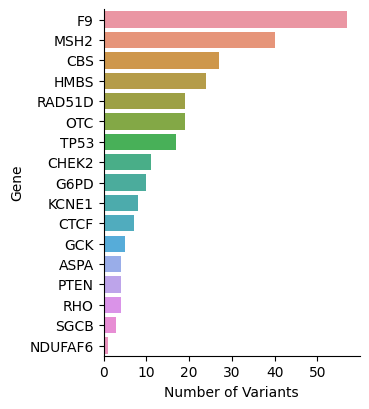

In [22]:
g = sns.catplot(data=varchamp_pillar_by_var_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)

### 3.2 Merge by genomic locations

In [23]:
varchamp_pillar_df = varchamp_clinvar_gnomad_df.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="full",
    coalesce=True
)

# display(varchamp_pillar_df.unique(subset="gene_variant"))
display(varchamp_pillar_df.drop_nulls(subset="pillar_tested").unique(subset="gene_variant"))

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""F9""","""ENSG00000101981""",52861,204356,"""CCSBVarC004377""","""ALE00004377""","""NC_000023.11:139541127:A:G""","""329A>G""","""Asp110Gly""","""CEGS2""","""CegsMutGDEh1027""","""D10""","""GDEhDisVCh_40052""","""B07""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""F9_Asp110Gly""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Asp110Gly""","""Asp110Gly""",true
"""ASPA""","""ENSG00000108381""",8459,15684,"""CCSBVarC001383""","""ALE00001383""","""NC_000017.11:3476230:A:G""","""71A>G""","""Glu24Gly""","""RC4""","""RC4_Mut_GDEh1016""","""D01""","""GDEhDisVCh_40040""","""C04""","""2""","""RC4_Mut_GDDh1016""","""D01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,7,1,1,0,null,null,0,null,null,0,null,null,"""ASPA_Glu24Gly""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Glu24Gly""","""Glu24Gly""",true
"""RAD51D""",null,7201,null,"""CCSBVarC024711""",null,"""NC_000017.11:35119546:T:C""",null,"""His23Arg""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RAD51D_His23Arg""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RAD51D_His23Arg""","""His23Arg""",true
"""SGCB""","""ENSG00000163069""",100010885,225815,"""CCSBVarC006986""","""ALE00006984""","""NC_000004.12:52029835:C:G""","""272G>C""","""Arg91Pro""","""CEGS2""","""CegsMutGDEh1043""",""

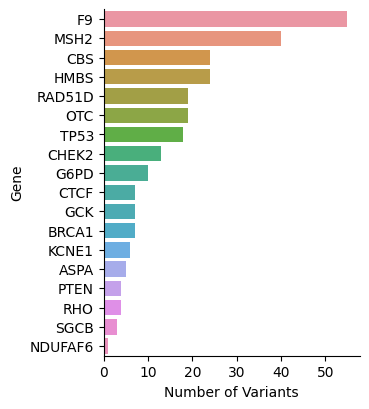

In [24]:
g = sns.catplot(data=varchamp_pillar_df.drop_nulls(subset="pillar_tested").unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)

In [25]:
varchamp_pillar_df.drop_nulls(subset="pillar_tested").filter(pl.col("gene_variant")==pl.col("gene_variant_pp")).unique(subset="gene_variant")

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""F9""",null,52861,null,"""CCSBVarC030586""",null,"""NC_000023.11:139561530:A:G""",null,"""His282Arg""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_His282Arg""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_His282Arg""","""His282Arg""",true
"""CBS""","""ENSG00000160200""",359,325,"""CCSBVarC007364""","""ALE00007352""","""NC_000021.9:43072061:G:A""","""133C>T""","""Arg45Trp""","""Edgotyping3""","""VUSMutGDEh011""","""H06""","""GDEhDisVCh_40013""","""A12""","""1""","""VUSMutGDDh011""","""H06""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,5,0,null,null,0,null,null,0,null,null,"""CBS_Arg45Trp""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CBS_Arg45Trp""","""Arg45Trp""",true
"""F9""","""ENSG00000101981""",52861,204374,"""CCSBVarC004385""","""ALE00004385""","""NC_000023.11:139561683:C:T""","""998C>T""","""Pro333Leu""","""CEGS2""","""CegsMutGDEh1025""","""C09""","""GDEhDisVCh_40052""","""A06""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""F9_Pro333Leu""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Pro333Leu""","""Pro333Leu""",true
"""CBS""","""ENSG00000160200""",359,280,"""CCSBVarC007328""","""ALE00007320""","""NC_000021.9:43065239:C:T""","""700G>A""","""Asp234Asn""","""Edgotyping3""","""VUSMutGDEh011""","""C02""","""GDEh

In [27]:
with pl.Config(tbl_rows=50):
    display(
        varchamp_pillar_df.drop_nulls(
            subset="pillar_tested"
        ).filter(
            pl.col("gene_variant")!=pl.col("gene_variant_pp")
        ).with_columns(
            pl.col("nuc_loc").cast(pl.Int32).alias("nuc_loc"),
            pl.col("gene_variant_pp").alias("gene_variant_pillar")
        ).select(
            pl.col(["ID", "Dataset", "gene_variant","gene_variant_pillar","Flag", "spdi",
                    "Chrom", "nuc_loc", "ref_allele", "alt_allele", "hgvs_p", 
                    "auth_transcript_id", "Ref_seq_transcript_ID", "Ensembl_transript_ID"])
        ).unique(subset="gene_variant").sort("gene_variant")
    )

ID,Dataset,gene_variant,gene_variant_pillar,Flag,spdi,Chrom,nuc_loc,ref_allele,alt_allele,hgvs_p,auth_transcript_id,Ref_seq_transcript_ID,Ensembl_transript_ID
str,str,str,str,str,str,str,i32,str,str,str,str,str,str
"""BRCA1_Adamovich_2022_Cisplatin…","""BRCA1_Adamovich_2022_Cisplatin""","""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""",null,"""NC_000017.11:43063909:C:G""","""17""",43063909,"""C""","""G""","""p.Gly1706Ala""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Adamovich_2022_HDR_var55…","""BRCA1_Adamovich_2022_HDR""","""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""",null,"""NC_000017.11:43051086:C:A""","""17""",43051086,"""C""","""A""","""p.Gly1770Val""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Adamovich_2022_Cisplatin…","""BRCA1_Adamovich_2022_Cisplatin""","""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""",null,"""NC_000017.11:43051104:A:G""","""17""",43051104,"""A""","""G""","""p.Leu1764Pro""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Adamovich_2022_HDR_var46…","""BRCA1_Adamovich_2022_HDR""","""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""",null,"""NC_000017.11:43070929:A:G""","""17""",43070929,"""A""","""G""","""p.Phe1662Ser""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Adamovich_2022_Cisplatin…","""BRCA1_Adamovich_2022_Cisplatin""","""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""",null,"""NC_000017.11:43063941:A:T""","""17""",43063941,"""A""","""T""","""p.Phe1695Ile""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Adamovich_2022_HDR_var48…","""BRCA1_Adamovich_2022_HDR""","""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""",null,"""NC_000017.11:43067628:G:A""","""17""",43067628,"""G""","""A""","""p.Thr1685Ile""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Adamovich_2022_HDR_var51…","""BRCA1_Adamovich_2022_HDR""","""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""",null,"""NC_000017.11:43057122:A:G""","""17""",43057122,"""A""","""G""","""p.Val1736Ala""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""CHK2_Gebbia_2024_var410573""","""CHK2_Gebbia_2024""","""CHEK2_Arg180Cys""","""CHEK2_Arg180""",null,"""NC_000022.11:28725031:G:A""","""22""",28725031,"""G""","""A""","""p.Arg180""",null,"""NM_007194.4""","""ENST00000404276.6"""
"""CHK2_Gebbia_2024_var411824""","""CHK2_Gebbia_2024""","""CHEK2_Glu239Lys""","""CHEK2_Glu239""",null,"""NC_000022.11:28711986:C:T""","""22""",28711986,"""C""","""T""","""p.Glu239""",null,"""NM_007194.4""","""ENST00000404276.6"""


In [28]:
varchamp_pillar_df.drop_nulls(
            subset="pillar_tested"
        ).filter(
            pl.col("gene_variant")!=pl.col("gene_variant_pp")
        ).with_columns(
            pl.col("nuc_loc").cast(pl.Int32).alias("nuc_loc"),
            pl.col("gene_variant_pp").alias("gene_variant_pillar")
        ).select(
            pl.col(["ID", "Dataset", "gene_variant","gene_variant_pillar","Flag", "spdi",
                    "Chrom", "nuc_loc", "ref_allele", "alt_allele", "hgvs_p", 
                    "auth_transcript_id", "Ref_seq_transcript_ID", "Ensembl_transript_ID"])
        ).unique(subset="gene_variant").sort(
    "gene_variant"
).write_csv("../3_outputs/mismatched_alleles.csv")

In [68]:
# varchamp_pillar_df.write_csv("../3_outputs/varchamp_alleles_with_pillar_annotations.tsv", separator="\t") #.unique(subset="spdi")

In [69]:
pillar_varchamp_df = pillar_clinvar_df.with_columns(
    pl.lit(True).alias("pillar_tested")
).join(
    varchamp_clinvar_gnomad_df.with_columns(
        pl.lit(True).alias("varchamp_collection")
    ),
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_vc",
    how="full",
    coalesce=True
)

# display(varchamp_pillar_df.unique(subset="gene_variant"))
# display(pillar_varchamp_df.drop_nulls(subset="varchamp_collection").unique(subset="gene_variant_vc"))
pillar_varchamp_df.write_csv("../3_outputs/pillar_alleles_with_varchamp_annotations.tsv", separator="\t") #.unique(subset="spdi")

In [67]:
# display(pillar_varchamp_df.drop_nulls(subset="varchamp_collection").unique(subset="gene_variant")["gene_variant"])

In [61]:
len([al for al in varchamp_pillar_df.drop_nulls(subset="pillar_tested").unique(subset="gene_variant")["gene_variant"] \
 if al not in pillar_varchamp_df.drop_nulls(subset="varchamp_collection").unique(subset="gene_variant")["gene_variant"]])

19

In [55]:
display(varchamp_pillar_df.drop_nulls(subset="pillar_tested").unique(subset="gene_variant")["gene_variant"])

gene_variant
str
"""CHEK2_Arg180Cys"""
"""RAD51D_Ile251Val"""
"""MSH2_Leu341Pro"""
"""OTC_Arg330Gly"""
"""F9_Cys407Arg"""
…
"""CHEK2_His143Arg"""
"""TP53_Leu344Pro"""
"""F9_Lys39Arg"""


## 4. Merging alleles from Malvika's codes

Scripts provided by Malvika to merge the alleles from VarChAMP with alleles from the Pillar Project.

In [25]:
# import re

# pp = pd.read_csv("../1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", low_memory=False)
# vc = pd.read_csv("../1_inputs/VarChampSeqConfirmationResult.tsv", sep="\t")

# pattern = r'NC_0*(\d+)\.\d+:(\d+):([ACGT]):([ACGT])'
# vc[['chromosome', 'position', 'ref', 'alt']] = vc['spdi'].str.extract(pattern)

# #replace 23 with X and 24 with Y to match PP dataframe
# vc['chromosome'] = vc['chromosome'].astype(str).replace({'23': 'X', '24': 'Y'})

# vc['chromosome'] = vc['chromosome'].astype(str).str.strip()
# pp['Chrom'] = pp['Chrom'].astype(str).str.strip()

# vc['ref'] = vc['ref'].astype(str).str.strip()
# vc['alt'] = vc['alt'].astype(str).str.strip()
# pp['ref_allele'] = pp['ref_allele'].astype(str).str.strip()
# pp['alt_allele'] = pp['alt_allele'].astype(str).str.strip()

# vc['position'] = vc['position'].astype(float)
# pp['hg38_start'] = pp['hg38_start'].astype(float)

# vc["gene_variant"] = vc["symbol"].str.strip() + "_" + vc["aa_change"].str.strip()
# # Now merge
# check = pd.merge(vc, pp, 
#                  left_on=['chromosome', 'position', 'ref', 'alt'],
#                  right_on=['Chrom', 'hg38_start', 'ref_allele', 'alt_allele'],
#                  how='inner')

In [ ]:
# check_pl = pl.DataFrame(check)
# check_pl["gene_variant"].unique()
# nm = check[check['ID'].isna()]

In [ ]:
# check.to_csv("~/IGVF-cvfg-pillar-project/varchamp_matched_variants_pp_060825.csv", index = None)
# nm.to_csv("~/IGVF-cvfg-pillar-project/varchamp_unmatched_variants_pp_060825.csv", index = None)